In [1]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, desc, when, count as spark_count, concat_ws, length, rand, row_number
from pyspark.sql.window import Window
import pandas as pd

def measure_time(func, *args, **kwargs):
    start = time.perf_counter()
    result = func(*args, **kwargs)
    end = time.perf_counter()
    return result, end - start

measure_time

<function __main__.measure_time(func, *args, **kwargs)>

In [2]:
spark = SparkSession.builder \
    .appName("RAID_TRAIN_TFIDF-LR_HUMAN-GPT4") \
    .master("spark://spark-master:7077") \
    .getOrCreate()

spark

In [3]:
df = spark.read.json("hdfs://namenode:8020/user/raid/filtered_minilm")
df

DataFrame[attack: string, domain: string, features: array<double>, generation: string, id: string, model: string]

# Total Baris

In [4]:
print("Menghitung total jumlah baris...")
total_rows, time_0 = measure_time(lambda: df.count())
print(f"✅ Total baris: {total_rows:,} | Waktu: {time_0:.4f} detik")

Menghitung total jumlah baris...
✅ Total baris: 1,869,542 | Waktu: 10.1393 detik


# Filter

In [5]:
print("Memfilter data: model IN ('human', 'gpt4')...")
df_filtered, filter_time = measure_time(
    lambda: df.filter(
        (col("model").isin(["human", "gpt4"]))
    )
)
print(f"✅ Filter selesai dalam {filter_time:.4f} detik")

Memfilter data: model IN ('human', 'gpt4')...
✅ Filter selesai dalam 0.0933 detik


In [6]:
print("Menghitung total jumlah baris setelah filter...")
total_rows, time_1 = measure_time(lambda: df_filtered.count())
print(f"✅ Total baris: {total_rows:,} | Waktu: {time_1:.4f} detik")

Menghitung total jumlah baris setelah filter...
✅ Total baris: 160,390 | Waktu: 9.2517 detik


In [7]:
df_filtered = df_filtered.repartition(32)
df_filtered

DataFrame[attack: string, domain: string, features: array<double>, generation: string, id: string, model: string]

# Split

In [8]:
print(f"[1] Total jumlah baris setelah filter...")
print(f"✅ Total baris: {total_rows:,} | Waktu: {time_1:.4f} detik")

[1] Total jumlah baris setelah filter...
✅ Total baris: 160,390 | Waktu: 9.2517 detik


In [9]:
print("[2] Membuat kolom stratifikasi 'model_domain_attack' ...")
df_with_strata, strat_time = measure_time(
    lambda: df_filtered.withColumn(
        "model_domain_attack",
        concat_ws("_", col("model"), col("domain"), col("attack"))
    )
)
print(f"✅ Kolom stratifikasi dibuat dalam {strat_time:.4f} detik")

[2] Membuat kolom stratifikasi 'model_domain_attack' ...
✅ Kolom stratifikasi dibuat dalam 0.0579 detik


In [10]:
df_with_strata = df_with_strata.repartition(32)
df_with_strata

DataFrame[attack: string, domain: string, features: array<double>, generation: string, id: string, model: string, model_domain_attack: string]

In [11]:
print("[3] Menghitung jumlah baris per 'model_domain_attack' ...")
df_counts, count_time = measure_time(
    lambda: df_with_strata.groupBy("model_domain_attack").agg(spark_count("*").alias("total_per_group"))
)
print(f"✅ Selesai dalam {count_time:.4f} detik")

[3] Menghitung jumlah baris per 'model_domain_attack' ...
✅ Selesai dalam 0.0247 detik


In [12]:
print("[4] Gabungkan count ke setiap baris")
df_joined, join_time = measure_time(
    lambda: df_with_strata.join(df_counts, on="model_domain_attack", how="inner")
)
print(f"✅ Data berhasil digabung dengan count per grup dalam {join_time:.4f} detik")

[4] Gabungkan count ke setiap baris
✅ Data berhasil digabung dengan count per grup dalam 0.0392 detik


In [13]:
print("[5] Memberi nomor urut acak dalam setiap grup ...")
window_spec = Window.partitionBy("model_domain_attack").orderBy(rand())
df_numbered, number_time = measure_time(
    lambda: df_joined.withColumn("row_num", row_number().over(window_spec))
)
print(f"✅ Penomoran selesai dalam {number_time:.4f} detik")

[5] Memberi nomor urut acak dalam setiap grup ...
✅ Penomoran selesai dalam 0.0298 detik


In [14]:
# [6] Tentukan batas 70% → masuk train jika row_num <= 0.7 * total_per_group
print("[6] Menentukan split berdasarkan 70% per grup ...")
df_with_split, split_time = measure_time(
    lambda: df_numbered.withColumn(
        "is_train",
        col("row_num") <= (col("total_per_group") * 0.7)
    )
)
print(f"✅ Split logic selesai dalam {split_time:.4f} detik")

[6] Menentukan split berdasarkan 70% per grup ...
✅ Split logic selesai dalam 0.0678 detik


In [15]:
# [7] Pisahkan train dan test
print("[7] Memisahkan train dan test ...")
train_df = df_with_split.filter(col("is_train")).drop("row_num", "total_per_group", "is_train")
test_df = df_with_split.filter(~col("is_train")).drop("row_num", "total_per_group", "is_train")

train_count, train_time = measure_time(lambda: train_df.count())
test_count, test_time = measure_time(lambda: test_df.count())

print(f"✅ Train: {train_count:,} baris (dalam {train_time:.4f} detik)")
print(f"✅ Test:  {test_count:,} baris (dalam {test_time:.4f} detik)")

[7] Memisahkan train dan test ...
✅ Train: 112,247 baris (dalam 13.3467 detik)
✅ Test:  48,143 baris (dalam 10.0238 detik)


In [16]:
# [8] Hitung distribusi di train
print("[8] Menghitung distribusi 'model_domain_attack' di train...")
train_dist = train_df.groupBy("model_domain_attack").count().withColumnRenamed("count", "train_count")

# [9] Hitung distribusi di test
print("[9] Menghitung distribusi 'model_domain_attack' di test...")
test_dist = test_df.groupBy("model_domain_attack").count().withColumnRenamed("count", "test_count")

# [10] Gabungkan train dan test berdasarkan label
print("[10] Menggabungkan distribusi train dan test...")
from pyspark.sql.functions import coalesce, lit, round as spark_round

# Hitung total keseluruhan untuk persentase
total_train = train_count
total_test = test_count

# Join full outer agar semua label muncul (meski hanya di train atau test)
combined = train_dist.join(test_dist, on="model_domain_attack", how="full_outer") \
    .fillna(0, subset=["train_count", "test_count"])

# Urutkan berdasarkan total frekuensi (opsional)
combined_sorted = combined.orderBy(col("train_count").desc())

# Ambil sebagai Pandas DataFrame untuk tampilan
print("[11] Mengambil hasil untuk ditampilkan...")
result_pd, fetch_time = measure_time(
    lambda: combined_sorted.toPandas()
)
print(f"✅ Berhasil mengambil {len(result_pd):,} kelas dalam {fetch_time:.4f} detik")

[8] Menghitung distribusi 'model_domain_attack' di train...
[9] Menghitung distribusi 'model_domain_attack' di test...
[10] Menggabungkan distribusi train dan test...
[11] Mengambil hasil untuk ditampilkan...
✅ Berhasil mengambil 64 kelas dalam 12.4837 detik


In [17]:
result_pd

,model_domain_attack,train_count,test_count
0,gpt4_books_alternative_spelling,2493,1069
1,gpt4_books_none,2493,1069
2,gpt4_books_paraphrase,2493,1069
3,gpt4_books_synonym,2493,1069
4,gpt4_news_alternative_spelling,2492,1068
...,...,...,...
59,human_abstracts_paraphrase,1235,530
60,human_reviews_alternative_spelling,660,283
61,human_reviews_none,660,283
62,human_reviews_synonym,660,283


# Train

In [18]:
from pyspark.ml.feature import (
    SQLTransformer, StringIndexer, RegexTokenizer,
    StopWordsRemover, HashingTF, IDF
)
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.types import FloatType

train_df, test_df

(DataFrame[model_domain_attack: string, attack: string, domain: string, features: array<double>, generation: string, id: string, model: string],
 DataFrame[model_domain_attack: string, attack: string, domain: string, features: array<double>, generation: string, id: string, model: string])

In [19]:
# --- 1. Siapkan hanya kolom teks (label akan diindex) ---
print("[12] Menyiapkan kolom 'text' dan 'label_string'...")
train_input = train_df.select(
    col("generation").alias("text"),
    col("model").alias("label_string")
)
test_input = test_df.select(
    col("generation").alias("text"),
    col("model").alias("label_string")
)

train_input = train_input.repartition(128)
test_input = test_input.repartition(128)

train_input, test_input

[12] Menyiapkan kolom 'text' dan 'label_string'...


(DataFrame[text: string, label_string: string],
 DataFrame[text: string, label_string: string])

In [20]:
# --- 2. Bangun pipeline dengan StringIndexer ---
print("[13] Membangun pipeline: StringIndexer → TF-IDF → LogisticRegression...")

# --- 1. Label encoder ---
string_indexer = StringIndexer(
    inputCol="label_string",
    outputCol="label",
    handleInvalid="error"
)

# --- 2. Normalisasi teks (huruf kecil & hilangkan simbol) ---
text_cleaner = SQLTransformer(
    statement="""
        SELECT *, 
        lower(regexp_replace(text, '[^a-zA-Z\\s]', '')) AS clean_text 
        FROM __THIS__
    """
)

# --- 3. Tokenizer & Stopwords remover ---
tokenizer = RegexTokenizer(
    inputCol="clean_text",
    outputCol="words",
    pattern="\\W"
)

stopwords_remover = StopWordsRemover(
    inputCol="words",
    outputCol="filtered"
)

# --- 4. TF-IDF ---
hashing_tf = HashingTF(
    inputCol="filtered",
    outputCol="raw_features",
    numFeatures=1000
)

idf = IDF(
    inputCol="raw_features",
    outputCol="features"
)

# --- 5. Logistic Regression ---
lr = LogisticRegression(
    featuresCol="features",
    labelCol="label",
    family="multinomial",
    regParam=0.1,
    maxIter=50
)

# --- 6. Gabungkan dalam pipeline ---
pipeline = Pipeline(stages=[
    string_indexer,
    text_cleaner,
    tokenizer,
    stopwords_remover,
    hashing_tf,
    idf,
    lr
])

pipeline

[13] Membangun pipeline: StringIndexer → TF-IDF → LogisticRegression...


Pipeline_5fb94a73533d

In [21]:
# --- 3. Latih model ---
print("[14] Melatih model pada train_input...")
model, train_model_time = measure_time(
    lambda: pipeline.fit(train_input)
)
print(f"✅ Model berhasil dilatih dalam {train_model_time:.4f} detik")

[14] Melatih model pada train_input...
✅ Model berhasil dilatih dalam 163.0516 detik


In [22]:
# --- 4. Simpan model ke HDFS ---
model_path = "hdfs://namenode:8020/user/raid/model-tfidf-lr_human-gpt4"
print(f"[15] Menyimpan model ke HDFS: {model_path}...")
_, save_time = measure_time(
    lambda: model.write().overwrite().save(model_path)
)
print(f"✅ Model disimpan dalam {save_time:.4f} detik")

[15] Menyimpan model ke HDFS: hdfs://namenode:8020/user/raid/model-tfidf-lr_human-gpt4...
✅ Model disimpan dalam 8.0311 detik


In [23]:
# --- 5. Prediksi pada test set ---
print("[16] Melakukan prediksi pada test_input...")
predictions, predict_time = measure_time(
    lambda: model.transform(test_input)
)
print(f"✅ Prediksi selesai dalam {predict_time:.2f} detik")

# Tampilkan contoh
predictions.select("text", "label_string", "label", "prediction").show(5, truncate=50)

[16] Melakukan prediksi pada test_input...
✅ Prediksi selesai dalam 0.12 detik
+--------------------------------------------------+------------+-----+----------+
|                                              text|label_string|label|prediction|
+--------------------------------------------------+------------+-----+----------+
|Ma pauvre muse, hélas! qu'as-tu donc ce matin?\...|       human|  1.0|       0.0|
|"An Intelligent Person’s Guide to Atheism" is a...|        gpt4|  0.0|       0.0|
|For the moment I do not know if this is the rig...|        gpt4|  0.0|       0.0|
| The book's four main characters are ecological...|       human|  1.0|       0.0|
|"Scarlet Feather" is a captivating novel that r...|        gpt4|  0.0|       0.0|
+--------------------------------------------------+------------+-----+----------+
only showing top 5 rows



In [24]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# --- 6. Evaluasi berbagai metrik ---
print("[17] Evaluasi...")

# Accuracy
evaluator_acc = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)
accuracy, time_acc = measure_time(lambda: evaluator_acc.evaluate(predictions))

# Weighted Precision
evaluator_prec = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="weightedPrecision"
)
precision, time_prec = measure_time(lambda: evaluator_prec.evaluate(predictions))

# Weighted Recall
evaluator_rec = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="weightedRecall"
)
recall, time_rec = measure_time(lambda: evaluator_rec.evaluate(predictions))

# F1-score (weighted)
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="f1"
)
f1_score, time_f1 = measure_time(lambda: evaluator_f1.evaluate(predictions))

# Tampilkan hasil
print(f"✅ Accuracy    : {accuracy:.4f} | Waktu: {time_acc:.4f} detik")
print(f"✅ Precision   : {precision:.4f} | Waktu: {time_prec:.4f} detik")
print(f"✅ Recall      : {recall:.4f} | Waktu: {time_rec:.4f} detik")
print(f"✅ F1-score    : {f1_score:.4f} | Waktu: {time_f1:.4f} detik")

[17] Evaluasi...
✅ Accuracy    : 0.6665 | Waktu: 27.2727 detik
✅ Precision   : 0.4442 | Waktu: 27.6336 detik
✅ Recall      : 0.6665 | Waktu: 29.4832 detik
✅ F1-score    : 0.5331 | Waktu: 29.2862 detik


In [25]:
print("[18] Membuat confusion matrix dengan label string...")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Ambil hasil prediksi ke Pandas
pred_pd, time_pred_pd = measure_time(lambda: predictions.select("label_string", "label", "prediction").toPandas())
print(f'✅ Selesai dalam {time_pred_pd:.4f} detik')
pred_pd

[18] Membuat confusion matrix dengan label string...
✅ Selesai dalam 32.9961 detik


,label_string,label,prediction
0,gpt4,0.0,0.0
1,human,1.0,0.0
2,gpt4,0.0,0.0
3,gpt4,0.0,0.0
4,gpt4,0.0,0.0
...,...,...,...
48138,gpt4,0.0,0.0
48139,human,1.0,0.0
48140,gpt4,0.0,0.0
48141,human,1.0,0.0


In [26]:
# Buat mapping label numerik ke string (gunakan data unik dari hasil prediksi)
label_map = (
    pred_pd[["label", "label_string"]]
    .drop_duplicates()
    .sort_values("label")
    .set_index("label")["label_string"]
    .to_dict()
)
label_map

{0.0: 'gpt4', 1.0: 'human'}

In [27]:
pred_pd["true_label"] = pred_pd["label"].map(label_map)
pred_pd["pred_label"] = pred_pd["prediction"].map(label_map)
pred_pd

,label_string,label,prediction,true_label,pred_label
0,gpt4,0.0,0.0,gpt4,gpt4
1,human,1.0,0.0,human,gpt4
2,gpt4,0.0,0.0,gpt4,gpt4
3,gpt4,0.0,0.0,gpt4,gpt4
4,gpt4,0.0,0.0,gpt4,gpt4
...,...,...,...,...,...
48138,gpt4,0.0,0.0,gpt4,gpt4
48139,human,1.0,0.0,human,gpt4
48140,gpt4,0.0,0.0,gpt4,gpt4
48141,human,1.0,0.0,human,gpt4


In [29]:
results_path = "hdfs://namenode:8020/user/raid/tfidf-lr_human-gpt4_results.parquet"
print(f"Menyimpan hasil ke HDFS: {results_path}...")
_, save_time = measure_time(
    lambda: predictions.select("label_string", "label", "prediction") \
        .write.mode("overwrite") \
        .parquet(results_path)
)
print(f"✅ Hasil disimpan dalam {save_time:.4f} detik")

Menyimpan hasil ke HDFS: hdfs://namenode:8020/user/raid/tfidf-lr_human-gpt4_results.parquet...
✅ Hasil disimpan dalam 33.9894 detik


In [30]:
# Ambil hanya label yang muncul di data
unique_labels = sorted(list(set(pred_pd["true_label"]) | set(pred_pd["pred_label"])))
len(unique_labels)

2

In [31]:
unique_labels

['gpt4', 'human']

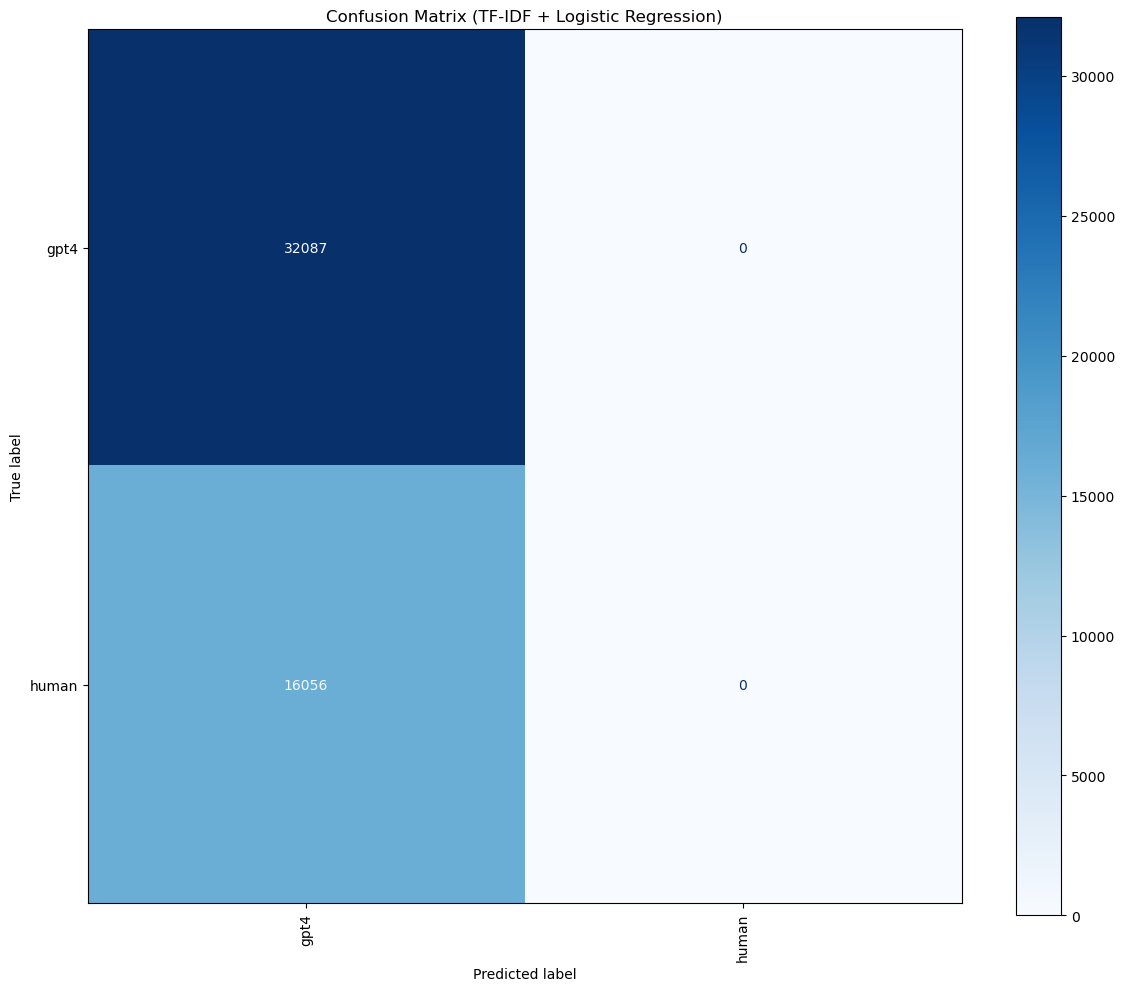

In [40]:
# Buat confusion matrix
cm = confusion_matrix(pred_pd["true_label"], pred_pd["pred_label"], labels=unique_labels)

# Visualisasi
fig, ax = plt.subplots(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
disp.plot(ax=ax, cmap="Blues", colorbar=True, xticks_rotation=90)
plt.title("Confusion Matrix (TF-IDF + Logistic Regression)")
plt.tight_layout()
plt.show()

In [49]:
spark.stop()